In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pystan

In [2]:
np.float64

numpy.float64

In [3]:
#Just a set rgb colors
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.) 

In [4]:
N = 1
I0 = 0.01
R0 = 0
S0 = (N - I0 - R0)
S = [S0]*100
R = [0]*100
I = [I0]*100
# S2 = S1[:]
# R2 = R1[:]
# I2 = I1[:]
# S3 = S1[:]
# R3 = R1[:]
# I3 = I1[:]
gamma_mu = 0.1
beta_mu = 0.6

# Gamma distribution
$$p(x) = x^{k-1}\frac{e^{-x/\theta}}{\theta^k\Gamma(k)},$$
$$k = \frac{\mu^2}{\sigma^2}$$
$$\theta = \frac{\sigma^2}{\mu} = \frac{\mu}{k}$$

# Beta distribution
$$p(x) = \frac{x^{\alpha-1}(1-x)^{\beta-1}}{B(\alpha, \beta)}$$
$$\alpha = \frac{\mu(1-\mu)-\sigma^{2}}{\sigma^{2}\Big(1+\frac{\sigma^{2}(1-\mu)}{\mu}\Big)}$$
$$\beta = \frac{\alpha(1-\mu)}{\mu}$$

In [5]:
# mu = beta_mu
# sigma2 = np.square(beta/3)
# a = (mu*(1-mu) - sigma2)/(sigma2*(1+((sigma2*(1-mu))/mu)))
# b = a*(1-mu)/mu
# beta = np.random.beta(a, b, 100)
# beta

In [6]:
mu = beta_mu
sigma2 = np.square(mu/2 + mu/6 + mu/24 + mu/120 + mu/720)
# sigma2 = np.square(mu/2)
k = np.square(mu/sigma2)
shape = k
scale = mu/k
beta = np.random.gamma(shape, scale, 100000).reshape(1000, 100)

In [7]:
mu = gamma_mu
# sigma2 = np.square(mu/2 + mu/3 + mu/4)
sigma2 = np.square(mu + mu/2 + mu/6 + mu/24 + mu/120)
k = np.square(mu/sigma2)
shape = k
scale = mu/k
gamma = np.random.gamma(shape, scale, 100000).reshape(1000, 100)
gamma

array([[0.10647487, 0.1042766 , 0.08418635, ..., 0.10761072, 0.07401575,
        0.08313412],
       [0.06727617, 0.07803228, 0.06491069, ..., 0.11631229, 0.13521356,
        0.14569363],
       [0.07348631, 0.12263894, 0.10065276, ..., 0.04502202, 0.10352979,
        0.12593988],
       ...,
       [0.05339239, 0.08031419, 0.12253155, ..., 0.05393273, 0.11105402,
        0.05046768],
       [0.09520242, 0.13766362, 0.11110097, ..., 0.07219387, 0.12207219,
        0.13225719],
       [0.13479253, 0.09006477, 0.07647822, ..., 0.07873617, 0.10495035,
        0.06273663]])

In [8]:
def r(R, beta, gamma):
    R0 = beta/gamma
    return gamma*(N - R - S0*(np.e**(-R0*R)))

# Alternative SIR formulation (Butcher's solver)

In [9]:
def A_SIR_Butcher_r(R, h, beta, gamma):
    for i in range(1, 100):
        k1 = r(R[i-1], beta[i], gamma[i])
        k2 = r(R[i-1] + (1/4)*k1*h, beta[i], gamma[i])
        k3 = r(R[i-1] + (1/8)*k1*h + (1/8)*k2*h, beta[i], gamma[i])
        k4 = r(R[i-1] - (1/2)*k2*h + k3*h, beta[i], gamma[i])
        k5 = r(R[i-1] + (3/16)*k3*h + (9/16)*k4*h, beta[i], gamma[i])
        k6 = r(R[i-1] - (3/7)*k1*h + (2/7)*k2*h + (12/7)*k3*h - (12/7)*k4*h + (8/7)*k5*h, beta[i], gamma[i])
        R[i] = R[i-1] + (1/90)*((7*k1) + (32 * k3) + (12 * k4) + (32 * k5) + (7*k6))*h
    return R

In [10]:
def A_SIR_Butcher(R, h, beta, gamma):
    for i in range(1, 100):
        k1 = r(R[i-1], beta, gamma)
        k2 = r(R[i-1] + (1/4)*k1*h, beta, gamma)
        k3 = r(R[i-1] + (1/8)*k1*h + (1/8)*k2*h, beta, gamma)
        k4 = r(R[i-1] - (1/2)*k2*h + k3*h, beta, gamma)
        k5 = r(R[i-1] + (3/16)*k3*h + (9/16)*k4*h, beta, gamma)
        k6 = r(R[i-1] - (3/7)*k1*h + (2/7)*k2*h + (12/7)*k3*h - (12/7)*k4*h + (8/7)*k5*h, beta, gamma)
        R[i] = R[i-1] + (1/90)*((7*k1) + (32 * k3) + (12 * k4) + (32 * k5) + (7*k6))*h
    return R

In [11]:
def dS(S, I, beta):
    return -beta*S*I

def dI(S, I, beta, gamma):
    return -dS(I, S, beta) - gamma*I

# SIR formulation (Butcher's solver)

In [12]:
def SIR_Butcher(S, I, h, beta, gamma):
    for i in range(99):
        k11 = dS(S[i], I[i], beta)
        k12 = dI(S[i], I[i], beta, gamma)

        k21 = dS(S[i] + (1/4)*k11*h, I[i] + (1/4)*k12*h, beta)
        k22 = dI(S[i] + (1/4)*k11*h, I[i] + (1/4)*k12*h, beta, gamma)

        k31 = dS(S[i] + (1/8)*k11*h + (1/8)*k21*h, I[i] + (1/8)*k12*h + (1/8)*k22*h, beta)
        k32 = dI(S[i] + (1/8)*k11*h + (1/8)*k21*h, I[i] + (1/8)*k12*h + (1/8)*k22*h, beta, gamma)

        k41 = dS(S[i] - (1/2)*k21*h + k31*h, I[i] - (1/2)*k22*h + k32*h, beta)
        k42 = dI(S[i] - (1/2)*k21*h + k31*h, I[i] - (1/2)*k22*h + k32*h, beta, gamma)

        k51 = dS(S[i] + (3/16)*k31*h + (9/16)*k41*h, I[i] + (3/16)*k32*h + (9/16)*k42*h, beta)
        k52 = dI(S[i] + (3/16)*k31*h + (9/16)*k41*h, I[i] + (3/16)*k32*h + (9/16)*k42*h, beta, gamma)

        k61 = dS(S[i] - (3/7)*k11*h + (2/7)*k21*h + (12/7)*k31*h - (12/7)*k41*h + (8/7)*k51*h, 
                 I[i] - (3/7)*k12*h + (2/7)*k22*h + (12/7)*k32*h - (12/7)*k42*h + (8/7)*k52*h, beta)
        k62 = dI(S[i] - (3/7)*k11*h + (2/7)*k21*h + (12/7)*k31*h - (12/7)*k41*h + (8/7)*k51*h,
                 I[i] - (3/7)*k12*h + (2/7)*k22*h + (12/7)*k32*h - (12/7)*k42*h + (8/7)*k52*h, beta, gamma)    

        S[i+1] = S[i] + (1/90)*((7*k11) + (32 * k31) + (12 * k41) + (32 * k51) + (7*k61))*h
        I[i+1] = I[i] + (1/90)*((7*k12) + (32 * k32) + (12 * k42) + (32 * k52) + (7*k62))*h
    return S, I

# SIR formulation (Ruge-Kutta solver)

In [13]:
def SIR_RK(S, I, h, beta, gamma):
    for i in range(99):
        k11 = dS(S[i], I[i], beta)
        k12 = dI(S[i], I[i], beta, gamma)
        k21 = dS(S[i] + (1/2)*k11*h, I[i] + (1/2)*k12*h, beta)
        k22 = dI(S[i] + (1/2)*k11*h, I[i] + (1/2)*k12*h, beta, gamma)
        k31 = dS(S[i] + (1/2)*k21*h, I[i] + (1/2)*k22*h, beta)
        k32 = dI(S[i] + (1/2)*k21*h, I[i] + (1/2)*k22*h, beta, gamma)
        k41 = dS(S[i] + k31*h, I[i] + k32*h, beta)
        k42 = dI(S[i] + k31*h, I[i] + k32*h, beta, gamma)
        S[i+1] = S[i] + (1/6)*((k11) + (2 * (k21 + k31)) + k41)*h
        I[i+1] = I[i] + (1/6)*((k12) + (2 * (k22 + k32)) + k42)*h
    return S, I

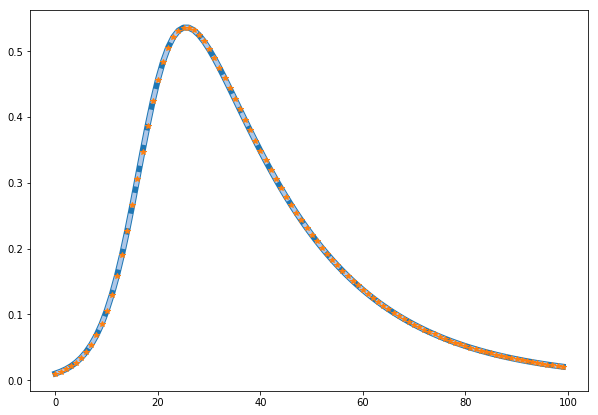

In [14]:
plt.figure(figsize=(10,7))
plt.plot(list(range(100)), N - np.array(A_SIR_Butcher(R, 0.5, beta_mu, gamma_mu)) - S0*np.exp(-beta_mu/gamma_mu*np.array(A_SIR_Butcher(R, 0.5, beta_mu, gamma_mu))), color=tableau20[0], linewidth=6)
plt.plot(list(range(100)), SIR_Butcher(S, I, 0.5, beta_mu, gamma_mu)[1], '--', color=tableau20[1], linewidth=4)
plt.plot(list(range(100)), SIR_RK(S, I, 0.5, beta_mu, gamma_mu)[1], '*', color=tableau20[2])
plt.savefig("test.png")

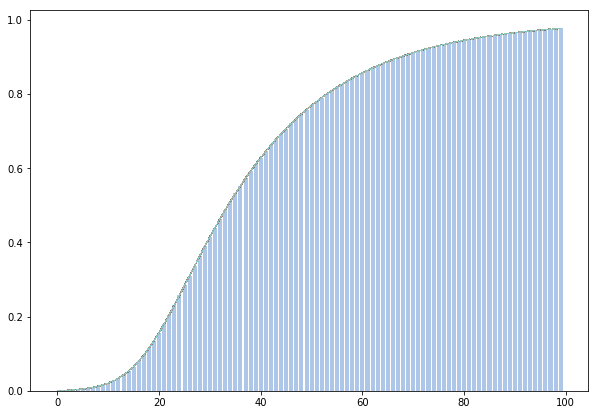

In [15]:
plt.figure(figsize=(10,7))
plt.bar(list(range(100)), np.array(A_SIR_Butcher(R, 0.5, beta_mu, gamma_mu)), color=tableau20[1])
for i in range(200):
    plt.plot(list(range(100)), np.array(A_SIR_Butcher(R, 0.5, beta_mu, gamma_mu)), '--', color=tableau20[i%20], linewidth=0.7)
#     plt.plot(list(range(100)), np.array(A_SIR_Butcher_r(R, 0.5, beta[i], gamma[i])), '--', color=tableau20[i%20], linewidth=0.7)
plt.savefig("R_randb.png")

In [16]:
drdt = np.array(A_SIR_Butcher(R, 0.5, beta_mu, gamma_mu))

$$\frac{dR}{dt} = \gamma(N - R - S_{0}e^{-\mathfrak{R}_{0}R})$$

In [17]:
np.savetxt("drdt.csv", drdt, delimiter=",")